In [6]:
import random
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

/home/amcalinden/miniconda3/envs/diffusion2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def set_seeds(seed):
    """Sets the seed for reproducible results across different libraries."""
    random.seed(seed) # Python's built-in random
    np.random.seed(seed) # NumPy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # PyTorch CUDA for all available GPUs
        # Optional: Additional settings for full CUDA reproducibility
        # Note: These might slow down execution
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

def write_to_disk(unet, path):
    unet.save_pretrained(path)
    print(f"Unet saved to {path}")

def load_from_disk(model_class, path):
    # Check for expected files (optional but good practice)
    safetensors_file = None
    config_file = os.path.join(path, 'config.json')

    # Look for a .safetensors file in the directory
    for file in os.listdir(path):
        if file.endswith('.safetensors'):
            safetensors_file = os.path.join(path, file)
            break

    print(f"Attempting to load model from {path} using {model_class.__name__}.from_pretrained")
    model = model_class.from_pretrained(path)

    # You can still calculate parameters if needed after loading
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

In [8]:
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/amcalinden/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7


In [9]:
path_train = os.path.join(path, "train")
outer_dir = os.listdir(path_train)
print("Num Classes:", len(outer_dir))
classes = []
for subfolder in outer_dir:
    subfolder_path = os.path.join(path_train, subfolder)
    if os.path.isdir(subfolder_path):
        inner_size = len(os.listdir(subfolder_path))
        classes.append((inner_size, subfolder))
classes.sort(reverse=True)
print("Classes sorted by number of images:")
for size, name in classes:
    print(f"  {name}: {size} images")

Num Classes: 80
Classes sorted by number of images:
  Butterfly: 1876 images
  Moths and butterflies: 1430 images
  Lizard: 1201 images
  Spider: 857 images
  Fish: 836 images
  Monkey: 771 images
  Eagle: 720 images
  Frog: 589 images
  Snake: 563 images
  Duck: 543 images
  Caterpillar: 495 images
  Sparrow: 476 images
  Jellyfish: 458 images
  Parrot: 422 images
  Owl: 407 images
  Horse: 401 images
  Ladybug: 393 images
  Tortoise: 392 images
  Chicken: 389 images
  Penguin: 378 images
  Snail: 371 images
  Squirrel: 368 images
  Deer: 328 images
  Tiger: 314 images
  Crab: 310 images
  Shark: 304 images
  Giraffe: 299 images
  Goose: 290 images
  Whale: 288 images
  Starfish: 249 images
  Harbor seal: 241 images
  Sea turtle: 240 images
  Swan: 234 images
  Polar bear: 230 images
  Rabbit: 217 images
  Rhinoceros: 215 images
  Lion: 209 images
  Goat: 203 images
  Centipede: 195 images
  Pig: 191 images
  Sea lion: 189 images
  Zebra: 182 images
  Woodpecker: 172 images
  Elephant

In [10]:
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    image_size = 128
    num_classes = 11
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    num_ddpm_steps = 1000
    num_epochs = 60
    lr = 1e-4
    num_warmup_steps = 500
    scale_factor= 0.18215
    seed = 423432

config = Hyperparameters()
set_seeds(config.seed)

Random seed set to 423432


In [11]:
top_classes = [tup[1] for tup in classes[:config.num_classes]]
print("Using classes:", top_classes)

Using classes: ['Butterfly', 'Moths and butterflies', 'Lizard', 'Spider', 'Fish', 'Monkey', 'Eagle', 'Frog', 'Snake', 'Duck', 'Caterpillar']


In [12]:
import AnimalDataset
from torch.utils.data import DataLoader

import importlib
importlib.reload(AnimalDataset)

print("Using device:", config.device)
dataset = AnimalDataset.AnimalDataset(path_train, top_classes, config.image_size, config.device)
train_loader = DataLoader(
    dataset,
    config.batch_size,
    shuffle=True,
)

Using device: cuda:2


In [22]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32)
vae.eval()
vae.requires_grad_(False)
vae.to(config.device)

unet = load_from_disk(UNet2DConditionModel, "top10_400m_60epoch")
unet.eval()
unet.requires_grad_(False)
unet.to(config.device)

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_ddpm_steps)

Attempting to load model from top10_400m_60epoch using UNet2DConditionModel.from_pretrained
Total parameters: 446,450,884
Trainable parameters: 446,450,884


In [18]:
def sample_from_model(config, vae, unet, noise_scheduler, text_embedding, latent_shape, num_samples=20):
    vae.eval()
    unet.eval()

    text_embedding = text_embedding.unsqueeze(0)
    text_embedding = text_embedding.expand(num_samples, -1, -1)

    latent_shape = torch.Size((num_samples,) + latent_shape[1:])
    latents = torch.randn(latent_shape).to(config.device)
    # latents *= config.scale_factor

    with torch.no_grad():
        for i in noise_scheduler.timesteps:
            # latent_inputs = noise_scheduler.scale_model_input(latents, i)
            model_pred = unet(latents, i, encoder_hidden_states=text_embedding).sample
            latents = noise_scheduler.step(model_pred, i, latents).prev_sample
        images = vae.decode(latents / config.scale_factor).sample
        images = (images / 2) + 0.5
        images = torch.clamp(images, 0, 1)
        return images

In [19]:
latent_shape = None
for imgs, embeddings in train_loader:
    imgs = imgs.to(config.device)
    embeddings = embeddings.to(config.device)
    latent = vae.encode(imgs).latent_dist.sample()
    latent_shape = latent.shape
    break
print("Latent shape:", latent_shape)

Latent shape: torch.Size([64, 4, 16, 16])


In [20]:
def make_grid(images, ncols=4):
    n = len(images)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()
    for i in range(n):
        axs[i].imshow(images[i].permute(1, 2, 0).cpu())
        axs[i].axis("off")
    for i in range(n, nrows * ncols):
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

Sampling images for class: Snake and Eagle


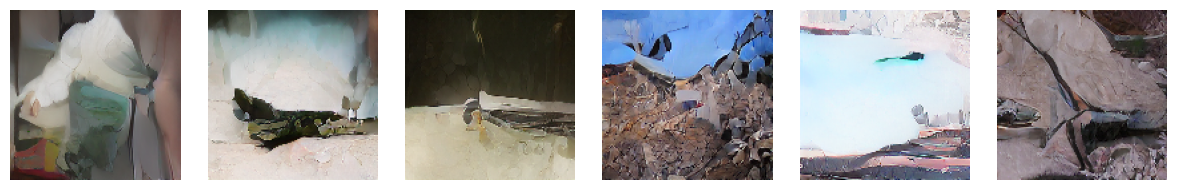

In [25]:
text = "Snake and Eagle"
print("Sampling images for class:", text)
cols = 6
embedding = dataset.get_embedding(text)
samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
make_grid(samples, ncols=cols)